In [36]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-9x64vunz
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-9x64vunz
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1694556533.224118390420868118806081040175592332373432988400-py3-none-any.whl size=301567 sha256=cec9c31c0599f15ff56b8f62008bc187af290418d6bbb9039796a045b414b672
  Stored in directory: /tmp/pip-ephem-wheel-cache-clz9x3ta/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [37]:
# Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Load dataset

The dataset `rooftop` is a subset of this [dataset](https://zenodo.org/record/5171712).
The dataset get uploaded to the Google Colab environment, and then unpacked and added to a dataset.

In [ ]:
!unzip "/content/rooftop.zip"

In [154]:
#dataset_images = tf.keras.utils.image_dataset_from_directory("/content/rooftop/images", labels=None, shuffle=False, batch_size = 2)
#dataset_masks = tf.keras.utils.image_dataset_from_directory("/content/rooftop/masks", labels=None, shuffle=False, batch_size = 2)
#dataset_masks = tf.keras.utils.image_dataset_from_directory("/content/rooftop/masks", labels=None, shuffle=False, color_mode="grayscale", batch_size = 2)
#dataset = tf.data.Dataset.zip((dataset_images, dataset_masks))
dataset_train, dataset_test = tf.keras.utils.image_dataset_from_directory(
    "/content/rooftop/images",
    labels=None,
    shuffle=True,
    validation_split=0.3,
    subset="both",
    batch_size=2,
    seed=42
    )

Found 138 files belonging to 1 classes.
Using 97 files for training.
Using 41 files for validation.


After the dataset is loaded, we can inspect the images and masks of those images.

In [12]:
def display(display_list):
    """
    Funciton that takes in a list of images to display them next to each other
    for comparision and investigation.

    Args:
        display_list (list): list of images to display
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    plt.show()

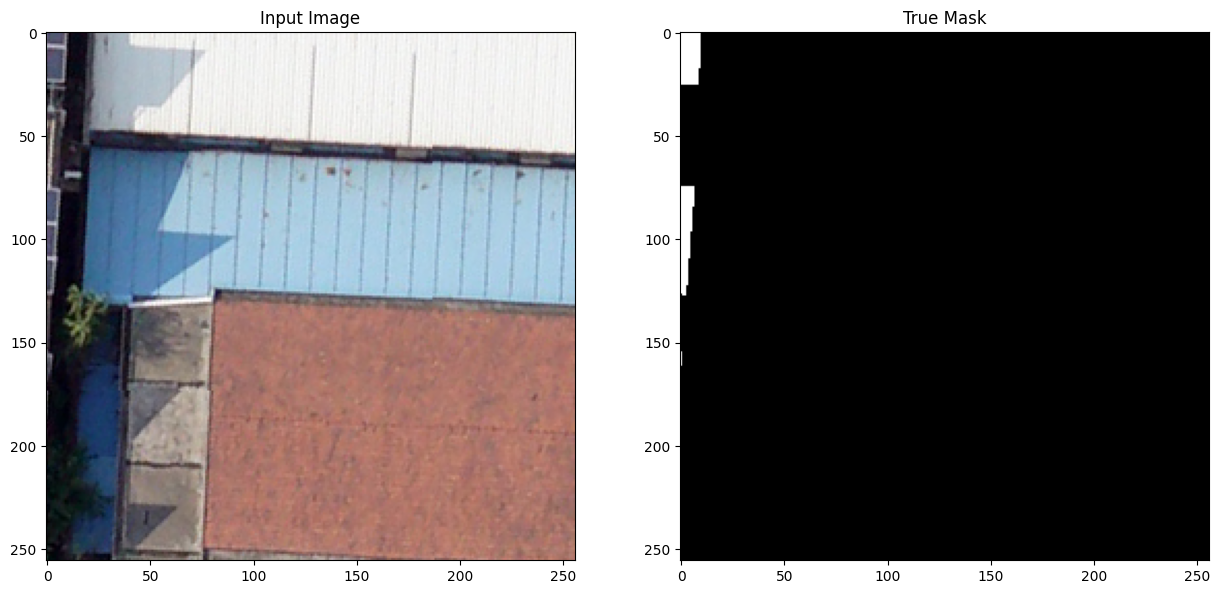

tf.Tensor(
[[[213. 213. 213.]
  [213. 213. 213.]
  [213. 213. 213.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[213. 213. 213.]
  [213. 213. 213.]
  [213. 213. 213.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[213. 213. 213.]
  [213. 213. 213.]
  [213. 213. 213.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 ...

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]], shape=(256, 256, 3), dtype=float32)


In [91]:
for image, mask in dataset_test.take(1):
    display([image[0], mask[0]])

# Building out the data pipeline

Now that we have the dataset loaded, we will create pipeline for augmenting and preparing the data for training.

In [23]:
class Preprocess(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.

        # Layers for both
        self.rescaling = tf.keras.layers.Rescaling(1.0/255)

        # Layers for images
        self.resizing_images = tf.keras.layers.Resizing(128, 128, interpolation='bilinear')

        # Layers for masks
        self.resizing_masks = tf.keras.layers.Resizing(128, 128, interpolation='nearest')

    def call(self, images, masks):
        images = self.rescaling(images)
        images = self.resizing_images(images)

        masks = self.rescaling(masks)
        masks = self.resizing_masks(masks)

        return images, masks

In [38]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        # Layers for images
        self.randomflip_images = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
        self.randomrotation_images = tf.keras.layers.RandomRotation(0.125, fill_mode='constant', interpolation='bilinear', fill_value=0.0, seed=seed)

        # Layers for masks
        self.randomflip_masks = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
        self.randomrotation_masks = tf.keras.layers.RandomRotation(0.125, fill_mode='constant', interpolation='nearest', fill_value=0.0, seed=seed)

    def call(self, images, masks):
        images = self.randomflip_images(images)
        images = self.randomrotation_images(images)
        masks = self.randomflip_masks(masks)
        masks = self.randomrotation_masks(masks)

        return images, masks

In [151]:
train_batches = (
    dataset#_train
    .cache()
    .shuffle(BUFFER_SIZE)
    #.batch(BATCH_SIZE)
    .repeat()
    .map(Preprocess())
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batches = (
    dataset_test
    #.batch(BATCH_SIZE)
    .map(Preprocess())
)

In [34]:
len(list(test_batches.as_numpy_iterator()))

41

In [ ]:
for image, mask in test_batches.take(1):
    #print(mask[0])
    display([image[0], mask[0]])

In [ ]:
# Download dataset
#dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [52]:
#TRAIN_LENGTH = info.splits['train'].num_examples
TRAIN_LENGTH = 97
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [129]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [130]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [131]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2, #kernel_size=3
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [132]:
OUTPUT_CLASSES = 2#3#2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

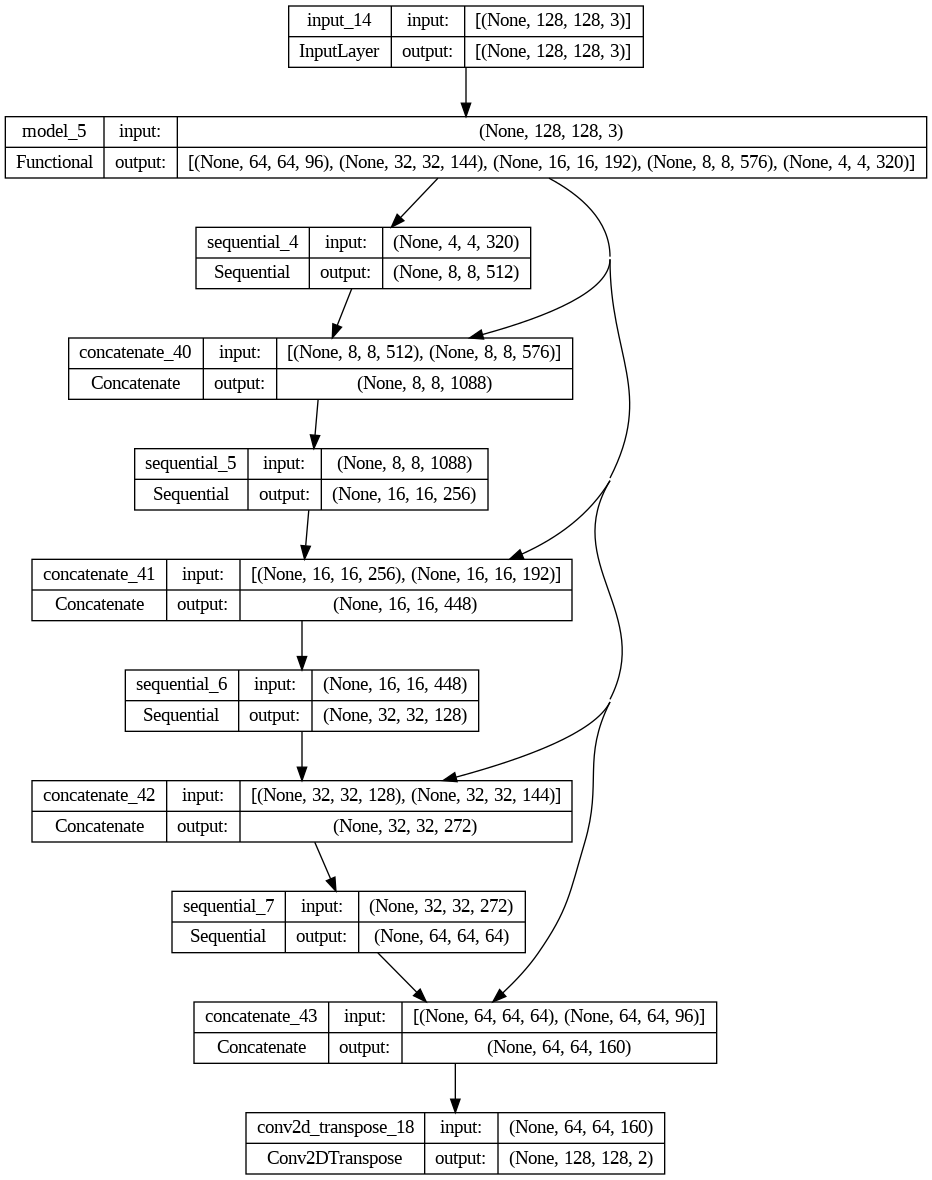

In [102]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [153]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  #display([sample_image, sample_mask])

InvalidArgumentError: ignored

In [134]:
for image, mask in train_batches.take(1):
      pred_mask = model.predict(image)



1/1 [==============================] - 1s 1s/step


In [135]:
pred_mask[0].shape

(128, 128, 2)

In [ ]:
pred_mask = tf.math.argmax(pred_mask[0], axis=-1)
pred_mask

In [ ]:
pred_mask = pred_mask[..., tf.newaxis]
pred_mask

In [108]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [109]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 70ms/step


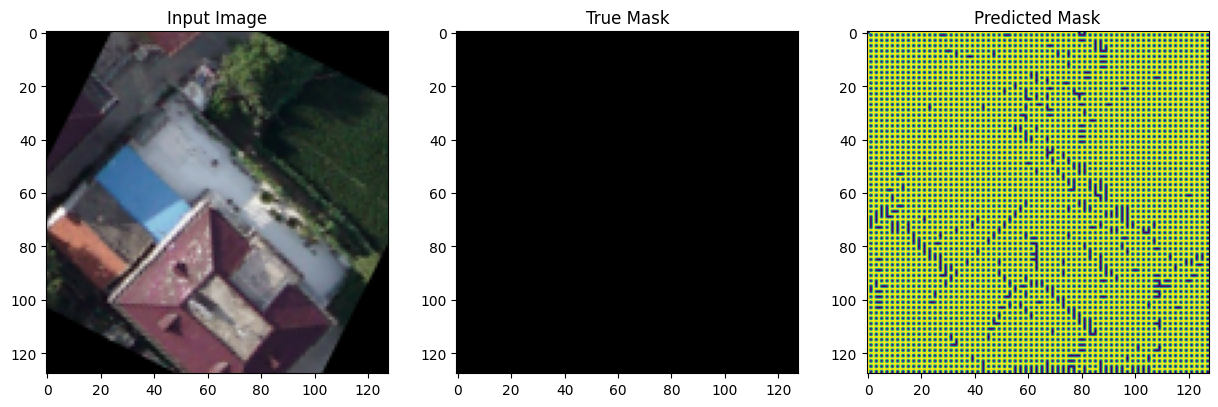

In [152]:
show_predictions()

In [51]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [145]:
for image, mask in train_batches.take(1):
    print(image.shape)
    print(mask.shape)

(2, 128, 128, 3)
(2, 128, 128, 3)


In [146]:
train_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(2, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 128, 128, 3), dtype=tf.float32, name=None))>

In [147]:
EPOCHS = 2
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_STEPS = 41//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          #validation_data=test_batches,
                          #callbacks=[DisplayCallback()])
                          )

Epoch 1/2


ValueError: ignored

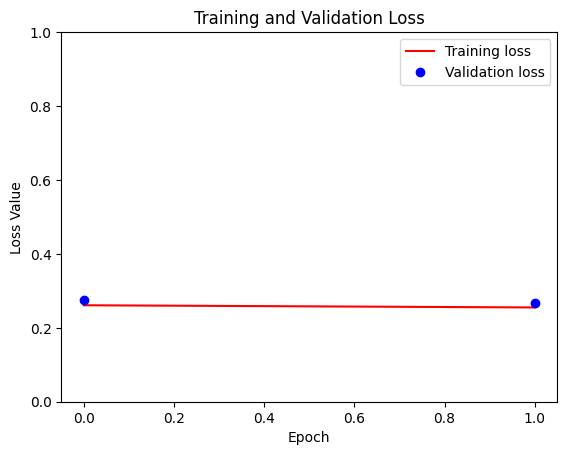

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 5s 3s/step


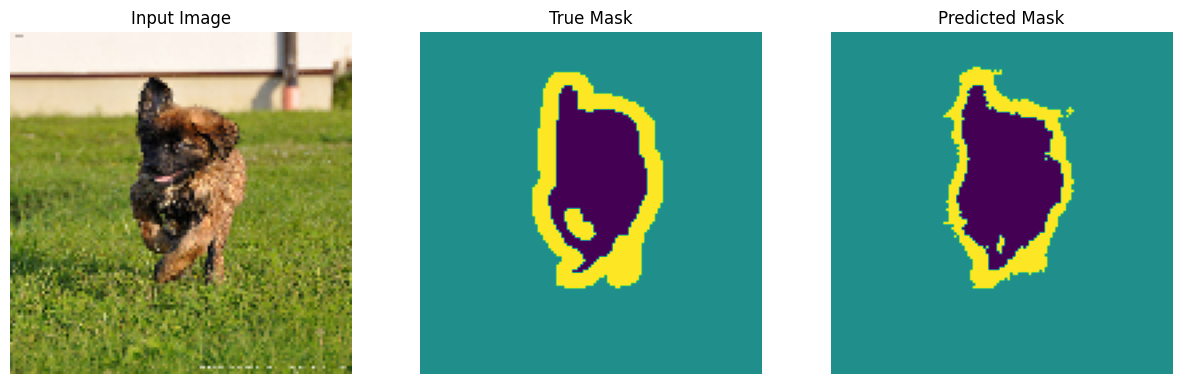

2/2 [==============================] - 4s 2s/step


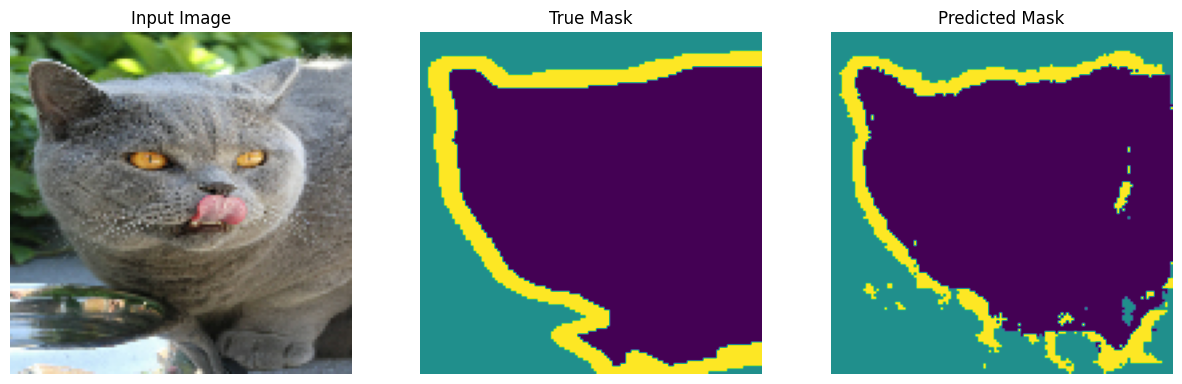

2/2 [==============================] - 5s 2s/step


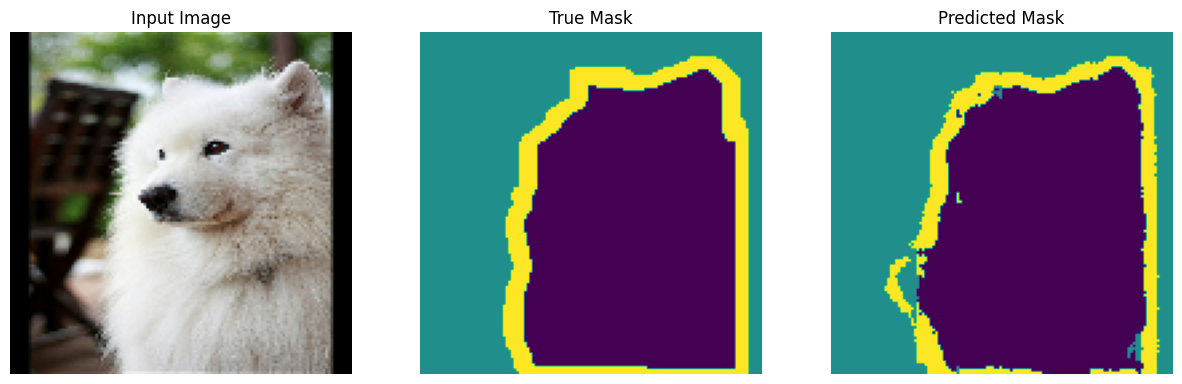

In [ ]:
show_predictions(test_batches, 3)

# Old

In [117]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

TypeError: ignored

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)